<H1>Dangerous Leak at Chemical Factory - Emergency Response with Autonomous Assessment Bot</H1>





Machine learning is assumed to be either supervised or unsupervised but a more recent approach is breaking the status-quo - reinforcement learning (RL). Supervised and unsupervised approaches require data to model, not reinforcement learning. RL is capable to explore space with a handful of instructions, analyze its surroundings one step at a time, and build its historical data as it learns.

In this walk-through, we’ll use Q-learning to find the shortest path between two areas. It has the ability to embark on a journey with no knowledge of what to do next. This approach requires constant trial and error as it collects data about its surroundings and figures out how to accomplish its goal. This opens up interesting possibilities, what about recording additional information, like environmental details along the way that it may not fully understand until after it reaches its goal? And once reached, could it review that additional data to determine if any of it would have helped it reach its goal faster?

**Q-learning**

According to Wikipedia, "Q-learning is a model-free reinforcement learning technique. Specifically, Q-learning can be used to find an optimal action-selection policy for any given (finite) Markov decision process (MDP)." (https://en.wikipedia.org/wiki/Q-learning)

**installing networkx on Python 3.x**

In [339]:
# installing networkx on Python 3.x 
# download and unzip networkx at https://pypi.python.org/pypi/networkx/#downloads
import os 
# os.chdir('/Users/manuel/Documents/emergency-response-rl-cbr-bot/networkx-2.1')
# !python setup.py install

<H2>Part 1: RL - Q-Learning Bot - Mapping Factory Floor for Dangerous Leak<BR></H2>
<B>Goal:</B> Find shortest path to leak for evaluation and response team<BR><BR>
    
Let's create a factory floor using the network mapping library <a href='https://networkx.github.io/' target='_blank'>networkz</a>. This can easily be done by creating a list of points representing each direction our bot can take to go from one end of the map to the other. Using this format allows us to easily create complex graphs but also easily visualize everything with networkx graphs. <BR><BR>
The map represents the chemical factory floor. The entrance is room is <b>0</b> and the room with the leak is <b>18</b>.<BR><BR>
Our bot will use Q-Learning

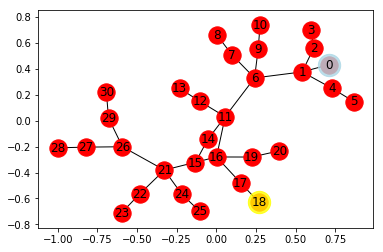

In [375]:
import numpy as np
import pylab as plt
import networkx as nx

# map cell to cell, add circular cell to goal point
point_list = [(0,1), (1,2), (2,3), (1,4), (4,5), (1,6), 
               (6,7), (7,8), (6,9), (9,10), (6,11), (11,12), 
               (12,13), (11,14), (14,15), (11,16), (16,17), (17,18),
               (16,19), (19,20), (16,21), (21,22), (22,23), (21,24), 
               (24,25), (21,26), (26,27), (27,28), (26,29), (29, 30)]

# goal point is where we have a leak
goal = 18
G=nx.Graph()
G.add_edges_from(point_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)

# highlight starting point
nx.draw_networkx_nodes(G, pos,
                       nodelist=[0],
                       node_color='lightblue',
                       node_size=500,
                       alpha=0.8)

# highlight end point
nx.draw_networkx_nodes(G, pos,
                       nodelist=[18],
                       node_color='yellow',
                       node_size=500,
                       alpha=0.8)
 
 
plt.show()


The map shows that point 0 is where our bot will start its search and point 18 is the leak, the goal point. The extra added points and false paths are obstacles the bot will have to contend with. 
<BR>
We then create the rewards graph - this is the matrix version of our list of points map. We initialize the matrix to be the height and width of our points list (31 in this example) and initialize all values to -1. We then change the values to be 0 if it is a viable path and 100 if it is a goal path (for more on this topic, see Mnemosyne_studio’s great tutorial: <a href='http://mnemstudio.org/path-finding-q-learning-tutorial.htm' target='_blank'>Deep Q Learning for Video Games - The Math of Intelligence #9</a>)

In [341]:
# how many points in graph? x points
MATRIX_SIZE = 31

# create matrix x*y
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1

In [342]:
# assign zeros to paths and 100 to goal-reaching point
for point in points_list:
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        # reverse of point
        R[point[::-1]]= 0

# add goal point round trip
R[goal,goal]= 100

 
R.shape

(31, 31)

Build a function to test the current best path with the actual best path

In [343]:
def test_best_path(Q, solution_path):
    current_state = 0
    steps = [current_state]
    while current_state != 18:
        next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
        if next_step_index.shape[0] > 1:
            next_step_index = int(np.random.choice(next_step_index, size = 1))
        else:
            next_step_index = int(next_step_index)
        steps.append(next_step_index)
        current_state = next_step_index
    if steps == solution_path:
        return steps, True
    else:
        return steps, False
        

The matrix is too big to show in this notebook but the y-axis is the state or where your bot is currently located, and the x-axis is your possible next actions. We then build our Q-learning matrix which will hold all the lessons learned from our bot. The Q-learning model uses a transitional rule formula and gamma is the learning parameter (see <a href='http://mnemstudio.org/path-finding-q-learning-tutorial.htm' target='_blank'>Deep Q Learning for Video Games - The Math of Intelligence #9</a> for more details). The rest of this example is mostly copied from Mic’s blog post <a href='http://firsttimeprogrammer.blogspot.com/2016/09/getting-ai-smarter-with-q-learning.html' target='_blank'>Getting AI smarter with Q-learning: a simple first step in Python</a>.

In [357]:
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# learning parameter
gamma = 0.8

initial_state = 1

def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

available_act = available_actions(initial_state) 

def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

action = sample_next_action(available_act)

def update(current_state, action, gamma):
    
  max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  
  if max_index.shape[0] > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q[action, max_index]
  
  Q[current_state, action] = R[current_state, action] + gamma * max_value
  # print('max_value', R[current_state, action] + gamma * max_value)
  
  if (np.max(Q) > 0):
    return(np.sum(Q/np.max(Q)*100))
  else:
    return (0)
    
update(initial_state, action, gamma)

0

We keep following Mic’s blog and run the training and testing functions that will run the update function 700 times allowing the Q-learning model to figure out the most efficient path:

569 True
583 True
591 True
592 True
593 True
594 True
Found most efficient path:
[0, 1, 6, 11, 16, 17, 18]


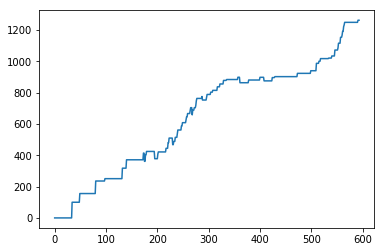

In [358]:
# Training
scores = []
wins_found = 0
for i in range(1000):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    steps, win = test_best_path(Q, [0, 1, 6, 11, 16, 17, 18])
    if (win):
        wins_found += 1
        print(i, win)
        if wins_found > 5:
            break;
    scores.append(score)

# Testing
current_state = 0
steps = [current_state]

# Testing
steps, win = test_best_path(Q, [0, 1, 6, 11, 16, 17, 18])
if win:
    print('Found most efficient path:')
else:
    print("Could not find most efficient path:")
print(steps)

plt.plot(scores)
plt.show()

So, as we would have guessed, it found the correct path to go from the entrance to the leak:
[0, 1, 6, 11, 16, 17, 18]

We see that the model did correctly find the most efficient path from the starting node 0 to the goal node 18 and took around 400 iterations to converge to a solution. 


<H2>Part 2: Analysis of Environmental Data</H2>
<B>Goal:</B> Model historic data and find correlations to emergency

Now, imagine that our bot was recording environmental data as it was scurrying through each rooms building its internal maps. For example, what if it recorded the temperature of each room on its journey. 

<TABLE>
    <TR><TD>11,16,21</TD><TD>2 degrees higher</TD></TR>
    <TR><TD>17, 18</TD><TD>5 degress higher</TD></TR>
</TABLE>

For example, using linear regression, we model the distance to leak from start using environment data and discover relationship between leak and temperature reading, the higher the reading get, the closer to the leak. The <b>blue</b> color represents a 2 degree higher temperature and the <b>red</b>, 4 degrees higher.

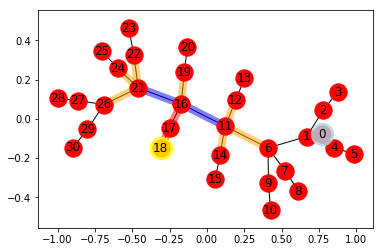

In [383]:

G=nx.Graph()
G.add_edges_from(point_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)

# highlight starting point
nx.draw_networkx_nodes(G, pos,
                       nodelist=[0],
                       node_color='lightblue',
                       node_size=500,
                       alpha=0.8)

# highlight end point
nx.draw_networkx_nodes(G, pos,
                       nodelist=[18],
                       node_color='yellow',
                       node_size=500,
                       alpha=0.8)

nx.draw_networkx_edges(G, pos,
                       edgelist=[(6,11),(11,12),(11,14),(16,19),(21,24),(21,26),(21,22)],
                       width=8, alpha=0.5, edge_color='orange')

nx.draw_networkx_edges(G, pos,
                       edgelist=[(16,17),(17,18)],
                       width=8, alpha=0.5, edge_color='red')

nx.draw_networkx_edges(G, pos,
                       edgelist=[(11,16),(16,21)],
                       width=8, alpha=0.5, edge_color='blue')
 
plt.show()

Let's create a temperature difference list and add the temperature differential at each point. We set all points to <b>0</b>, some to <b>+2</b> and the point leading the goal to <b>+5</b> and the goal to <b>+10</b> degrees. And the way we are going to suggest to the Q-Learning model to favorize paths with a rising temperature is to drop a certain amount of 'next actions' that are decreasing in temperature (not all as we want to handle certain noisy situations). 

In [360]:
# let's add our temparature readings
temperature_differential_readings = [0] * 31
temperature_differential_readings[6] = 1
temperature_differential_readings[12] = 1
temperature_differential_readings[14] = 1
temperature_differential_readings[19] = 1
temperature_differential_readings[24] = 1
temperature_differential_readings[26] = 1
temperature_differential_readings[22] = 1
temperature_differential_readings[11] = 2
temperature_differential_readings[16] = 2
temperature_differential_readings[21] = 2
temperature_differential_readings[17] = 5
temperature_differential_readings[18] = 10

<H2>Part 3: Factory with Dangerous Leak - Using Enhanced Q-Learning with Case-based reasoning (CBR)</H2>
<B>Goal:</B> Find shortest path to leak for evaluation and response team


**Case-based reasoning (CBR)**

"Case-based reasoning (CBR), broadly construed, is the process of solving new problems based on the solutions of similar past problems." (https://en.wikipedia.org/wiki/Case-based_reasoning)

We create the same factory map with the same story, suffering from same chemical leak (where temperature relationship applies). We fire off the bot using an enhanced Q-Learning algorithm with CBR, to attempt to favorize steps with increasing temperatures versus steps with decreasing ones or non-changing ones. 

In [363]:
# re-initialize the matrices for new run
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# learning parameter
gamma = 0.8



initial_state = 1

def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

available_act = available_actions(initial_state) 

# we add past action to know where we're coming from
def sample_next_action(available_actions_range, past_action):
    # see if we can go up in temperature
    found_rising_temp_path = False
    for act in available_act:
        if temperature_differential_readings[past_action] < temperature_differential_readings[int(act)]:
            next_action = int(act)
            found_rising_temp_path = True
            break;
    
    if found_rising_temp_path == False:
        next_action = int(np.random.choice(available_act,1))
   
    return next_action

action = sample_next_action(available_act, 0)

def update(current_state, action, gamma):
    
  max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  
  if max_index.shape[0] > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q[action, max_index]
  
  Q[current_state, action] = R[current_state, action] + gamma * max_value
  # print('max_value', R[current_state, action] + gamma * max_value)
  
  if (np.max(Q) > 0):
    return(np.sum(Q/np.max(Q)*100))
  else:
    return (0)
    
update(initial_state, action, gamma)

0

402 True
431 True
432 True
433 True
434 True
435 True
Found most efficient path:
[0, 1, 6, 11, 16, 17, 18]


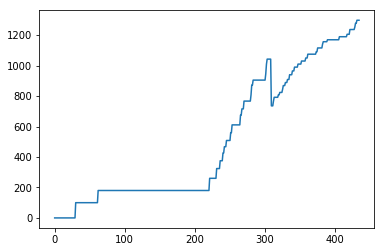

In [364]:
# re-initialize the matrices for new run
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))


scores = []
wins_found = 0
for i in range(1000):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act, action)
    score = update(current_state,action,gamma)
    steps, win = test_best_path(Q, [0, 1, 6, 11, 16, 17, 18])
    if (win):
        wins_found += 1
        print(i, win)
        if wins_found > 5:
            break;
    scores.append(score)
    
# Testing
steps, win = test_best_path(Q, [0, 1, 6, 11, 16, 17, 18])
if win:
    print('Found most efficient path:')
else:
    print("Could not find most efficient path:")

print(steps)

plt.plot(scores)
plt.show()

You may need to run both examples a couple of times in order to see patterns emerge. Overall, it only takes our CBR enhanced model a half to two-thirds the time to reach the leak than the original approach. This is a toy problem but the ramifications of using RL to map areas along with the ability of recording additional data of which the immediate use may not be apparent opens up interesting possibilites. This is a bit like unsupervised learning where we don't quite know what we are going to learn but at times can be very profitable. 